In [23]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [24]:
tf.keras.backend.set_floatx('float64')

In [25]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = None #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'control'

In [26]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [27]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(50,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [28]:
agent.train(env,1000,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('UniversalRNN-'+str(condition))

0 0.4955
1 0.506
2 0.503
3 0.50475
4 0.5013
5 0.5036666666666666
6 0.506
7 0.512125
8 0.5165555555555557
9 0.5227000000000002
10 0.52965
11 0.5348499999999999
12 0.5418499999999999
13 0.5475
14 0.5562499999999999
15 0.5624
16 0.56805
17 0.57105
18 0.5730999999999999
19 0.5738
20 0.5749500000000001
21 0.57465
22 0.5744
23 0.5761499999999999
24 0.5761999999999999
25 0.5782999999999999
26 0.58005
27 0.5816000000000001
28 0.58495
29 0.5856
30 0.5864
31 0.5905000000000001
32 0.5945
33 0.5967
34 0.5983
35 0.5981500000000001
36 0.5993999999999999
37 0.5989000000000002
38 0.5968500000000001
39 0.5996500000000001
40 0.6032000000000001
41 0.6037000000000001
42 0.60445
43 0.6069500000000001
44 0.60955
45 0.6124499999999999
46 0.6117999999999999
47 0.6134
48 0.6155999999999999
49 0.61565
50 0.6156499999999999
51 0.61485
52 0.61565
53 0.6146
54 0.6156499999999999
55 0.6145
56 0.61645
57 0.6189500000000001
58 0.6201
59 0.6207999999999999
60 0.6205499999999999
61 0.62025
62 0.6211
63 0.6233
64 0.6210

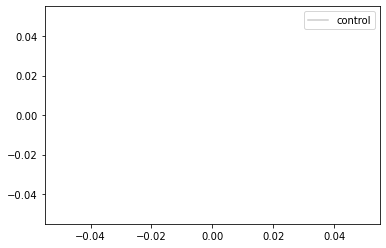

In [43]:
%matplotlib inline
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [30]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(50,activation=activation,noise=rnn_noise,random_training=random_training)
agent.postname = condition #Set path name for saving and loading

In [31]:
agent.load('UniversalRNN-'+str(condition))

LOADING ['nn', 'out_nn']


In [32]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [33]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [34]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [35]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [47]:
out = agent.nn(batch_obs).numpy()
choice = agent.predict(batch_obsf).numpy()

In [37]:
#Residue ref
ref = batch_obsf.get('obs')[:,:,2:].reshape((-1,2))
out = residue(out,ref)

#Residue choice
#choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
#out = residue(out, choice_batch)

score 0.34989731650733213


In [48]:
#fit pca
pca = fit_pca(out.reshape((-1,50)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,50))).reshape(out.shape[:-1]+(nb_variance,))

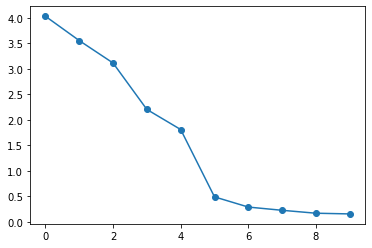

In [49]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [40]:
#Plot background function
def plot_bg(pca_batch,zorder=0):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('pca1')
    ax.set_ylabel('pca2')
    ax.set_zlabel('pca3')
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    for i in range(pca_batch.shape[1]):
        ax.scatter(pca_batch[:,i,0],pca_batch[:,i,1],pca_batch[:,i,2],color=colors[i],alpha=0.1,marker='.',zorder=zorder)

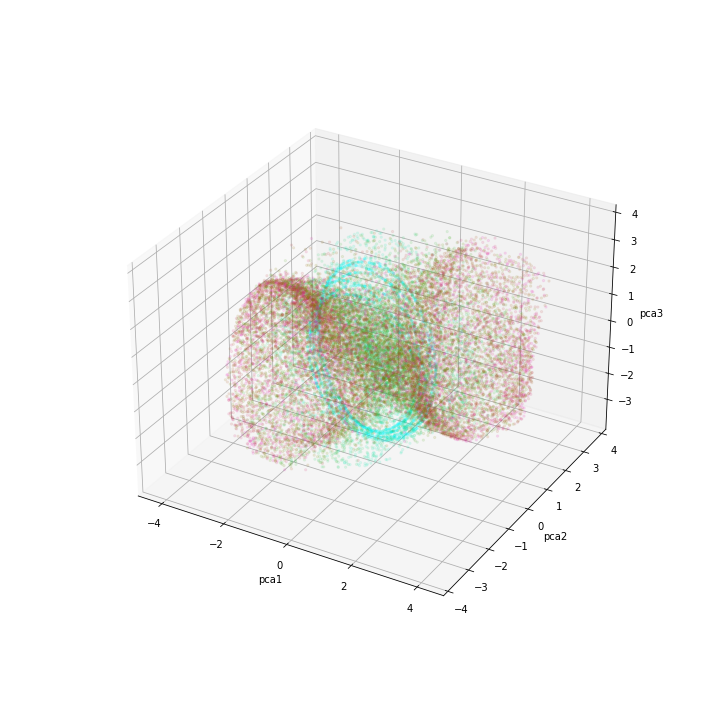

In [46]:
%matplotlib widget
from mpl_toolkits import mplot3d
plot_bg(pca_batch)
plt.show()